# Regressão Linear: Simples vs Múltipla (com gráfico e comparação de métricas)

Este notebook é um tutorial prático que demonstra e compara dois tipos de regressão linear usando um dataset corporativo. O arquivo **dataset_corporativo_ml_1000.csv** contém dados de vendas e marketing de uma empresa, e vamos usá-lo para:

1) **Regressão Linear Simples**: 
   - Usaremos apenas uma variável explicativa (`invest_marketing`) para prever a `receita`
   - Exemplo da relação: `receita ~ invest_marketing`
   - Isso nos mostra a relação direta entre investimento em marketing e receita

2) **Regressão Linear Múltipla**:
   - Usaremos várias variáveis explicativas, tanto numéricas quanto categóricas
   - Isso nos dá um modelo mais completo, considerando mais fatores que podem influenciar a receita

3) **Análise Completa**:
   - Comparação de métricas de performance (R², RMSE, MAE)
   - Visualizações gráficas:
     - Linha de regressão simples
     - Gráficos de `y_real` vs `y_predito`
     - Análise de resíduos
   - Isso nos ajuda a entender qual modelo é melhor e por quê

In [1]:
# Bibliotecas básicas
import os             # Para manipulação de arquivos e diretórios no sistema operacional
import numpy as np    # Para operações numéricas e arrays (matrizes) eficientes
import pandas as pd   # Para manipulação e análise de dados em formato tabular
import matplotlib.pyplot as plt  # Para criar visualizações e gráficos

# Importações do scikit-learn (sklearn) para machine learning
from sklearn.model_selection import train_test_split  # Para dividir dados em treino e teste
from sklearn.compose import ColumnTransformer        # Para aplicar diferentes transformações em diferentes colunas
from sklearn.preprocessing import OneHotEncoder      # Para converter variáveis categóricas em numéricas
from sklearn.preprocessing import StandardScaler     # Para padronizar variáveis numéricas (média 0, desvio 1)
from sklearn.linear_model import LinearRegression   #O modelo de regressão linear que vamos usar
from sklearn.metrics import r2_score                # Para calcular o coeficiente de determinação (R²)
from sklearn.metrics import mean_squared_error      # Para calcular o erro quadrático médio
from sklearn.metrics import mean_absolute_error     # Para calcular o erro absoluto médio
from sklearn.inspection import permutation_importance  # Para análise de importância das features
from sklearn.pipeline import Pipeline # Para criar um pipeline de processamento

In [2]:
# ==============================
# Carregar o dataset
# ==============================

# Carrega o arquivo CSV de dados corporativos usando pandas
# O arquivo deve estar na mesma pasta que este notebook
df = pd.read_csv("dataset_corporativo_ml_1000.csv")  # Lê o arquivo CSV para um DataFrame
                                                     # DataFrame é como uma planilha do Excel no Python

# Vamos examinar os dados carregados:

# 1. Verifica o tamanho do dataset
print("Dimensões:", df.shape)  # Mostra (número de linhas, número de colunas)

# 2. Visualiza as primeiras linhas do dataset
print("\nPrimeiras 5 linhas do dataset:")  # \n cria uma linha em branco antes
display(df.head())  # Mostra as 5 primeiras linhas para termos uma ideia dos dados

# 3. Verifica os tipos de dados de cada coluna
print("\nTipos de dados de cada coluna:")  # \n cria uma linha em branco antes
display(df.dtypes)  # Mostra se as colunas são números, texto, datas, etc.

Dimensões: (1000, 20)

Primeiras 5 linhas do dataset:


,data,regiao,canal,produto,invest_marketing,ligacoes_vendas,visitas_site,emails_enviados,preco,preco_concorrente,desconto_pct,satisfacao,tickets_suporte,cliente_recorrente,sazonalidade_mes,unidades_vendidas,receita,transacoes,ticket_medio,lead_vai_comprar
0,2023-01-01,Sul,Representante,A,942.0,11,1526,705,93.08,99.09,0.081,5.00,0,0,1,110,9411.96,68,138.41,1
1,2023-01-01,Nordeste,Representante,B,704.0,9,822,713,121.58,127.82,0.072,5.00,1,1,1,90,10157.31,105,96.74,1
2,2023-01-01,Centro-Oeste,Loja Física,B,4140.0,12,2633,875,103.30,100.27,0.028,3.41,2,0,1,171,17162.47,238,72.11,1
3,2023-01-02,Centro-Oeste,Loja Física,B,3079.0,7,1647,1381,115.55,118.59,0.089,3.42,0,0,1,132,13894.26,144,96.49,1
4,2023-01-02,Centro-Oeste,Online,A,1759.0,4,2724,1499,116.14,121.23,0.085,3.79,0,0,1,192,20413.12,178,114.68,1



Tipos de dados de cada coluna:


data                   object
regiao                 object
canal                  object
produto                object
invest_marketing      float64
ligacoes_vendas         int64
visitas_site            int64
emails_enviados         int64
preco                 float64
preco_concorrente     float64
desconto_pct          float64
satisfacao            float64
tickets_suporte         int64
cliente_recorrente      int64
sazonalidade_mes        int64
unidades_vendidas       int64
receita               float64
transacoes              int64
ticket_medio          float64
lead_vai_comprar        int64
dtype: object

In [3]:
# ==============================
# Configurações principais
# ==============================
# Definimos aqui as variáveis principais que controlam o experimento

# Define a coluna alvo (variável dependente) que queremos prever
TARGET_COL = "receita"          # Nossa variável de interesse: a receita da empresa

# Define a única variável explicativa usada na regressão simples
SIMPLE_FEATURE = "invest_marketing"  # Vamos ver como o investimento em marketing afeta a receita

# Define um conjunto de colunas que não devem ser usadas na regressão múltipla
EXCLUDE_FROM_MULTIPLE = {
    TARGET_COL,          # Não podemos usar a receita para prever ela mesma
    "ticket_medio",      # Ticket médio é calculado da receita, então não pode ser usado
    "data"              # Não usaremos a data diretamente, já conhecemos a sazonalidade
}

# Parâmetros para divisão dos dados e reprodutibilidade
TEST_SIZE = 0.20        # 20% dos dados serão usados para teste
RANDOM_STATE = 42       # Semente aleatória para garantir que sempre teremos a mesma divisão

In [4]:
# ==============================
# Seleção de colunas numéricas e categóricas
# ==============================
# Separa automaticamente as colunas em numéricas e categóricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()      # Seleciona colunas com números
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()  # Seleciona colunas com texto/categorias

# Remove as colunas que não queremos usar como preditoras
# List comprehension: cria nova lista filtrando as colunas que não estão nas exclusões
numeric_features = [c for c in numeric_cols if c not in EXCLUDE_FROM_MULTIPLE and c != TARGET_COL]  # Features numéricas finais
categorical_features = [c for c in categorical_cols if c not in EXCLUDE_FROM_MULTIPLE]              # Features categóricas finais

# Mostra um resumo das variáveis selecionadas
print("Alvo:", TARGET_COL)                              # Mostra qual variável vamos prever
print("Feature simples:", SIMPLE_FEATURE)               # Mostra qual variável usaremos na regressão simples
print("\nNuméricas (múltipla):", numeric_features)      # Lista todas features numéricas para regressão múltipla
print("\nCategóricas (múltipla):", categorical_features) # Lista todas features categóricas para regressão múltipla

# ==============================
# Definir X e y
# ==============================
# Extrair a variável alvo (y) do DataFrame
y = df[TARGET_COL].values  # Converte para array numpy
X_simple = df[[SIMPLE_FEATURE]].values  # Extrai apenas a coluna do investimento em marketing

# Preparar dados para regressão múltipla
X_multi = df[numeric_features + categorical_features].copy()  # Seleciona todas as features escolhidas

# ==============================
# Divisão Treino/Teste (mesma partição para simples e múltipla)
# ==============================
# Criar índices para dividir os dados
indices = np.arange(len(df))  # Cria array com índices de 0 até n-1
# Divide os índices em treino e teste
idx_train, idx_test = train_test_split(indices, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Aplica a divisão nos dados da regressão simples
Xtr_simple, Xte_simple = X_simple[idx_train], X_simple[idx_test]  # Divide X_simple
ytr, yte = y[idx_train], y[idx_test]  # Divide y (mesmo para ambas regressões)

# Aplica a divisão nos dados da regressão múltipla
Xtr_multi = X_multi.iloc[idx_train].copy()  # Dados de treino para regressão múltipla
Xte_multi = X_multi.iloc[idx_test].copy()   # Dados de teste para regressão múltipla

Alvo: receita
Feature simples: invest_marketing

Numéricas (múltipla): ['invest_marketing', 'ligacoes_vendas', 'visitas_site', 'emails_enviados', 'preco', 'preco_concorrente', 'desconto_pct', 'satisfacao', 'tickets_suporte', 'cliente_recorrente', 'sazonalidade_mes', 'unidades_vendidas', 'transacoes', 'lead_vai_comprar']

Categóricas (múltipla): ['regiao', 'canal', 'produto']


In [5]:
# ==============================
# Treino dos modelos
# ==============================
# 1) Regressão Linear Simples (sem pré-processamento)
lr_simple = LinearRegression()                # Cria o modelo de regressão linear simples
lr_simple.fit(Xtr_simple, ytr)               # Treina o modelo com os dados de treino

# 2) Regressão Linear Múltipla com pré-processamento
# Configura as transformações para as features
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),         # Padroniza as variáveis numéricas (-3 a +3 aprox.)
        ("cat", OneHotEncoder(                              # Converte categorias em colunas 0/1
            drop="first",                                   # Remove uma categoria para evitar multicolinearidade
            handle_unknown="ignore"                         # Ignora categorias novas no teste
        ), categorical_features),   
    ],
    remainder="drop"                                        # Remove colunas não especificadas
)

In [6]:
# Cria o modelo de regressão múltipla
lr_multi = LinearRegression()
# Cria um pipeline que combina pré-processamento e modelo
pipe_multi = Pipeline(steps=[
    ("prep", preprocess),     # Primeiro aplica o pré-processamento
    ("model", lr_multi)       # Depois treina o modelo
])


# Treina o pipeline completo
pipe_multi.fit(Xtr_multi, ytr)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
# ==============================
# Predições
# ==============================
# Faz previsões com o modelo simples
# Não fazemos pré-processamento na simples, pois é só uma variável numérica
ypred_simple = lr_simple.predict(Xte_simple)  # Prevê valores para os dados de teste

# Faz previsões com o modelo múltiplo
ypred_multi = pipe_multi.predict(Xte_multi)   # Prevê valores para os dados de teste

In [8]:
#APENAS DEMONSTRAÇÃO - MOSTRAR DATASET TRANSFORMADO
# ColumnTransformer ajustado no pipeline, para podermos transformar os dados, pqis precisamos ver como ficaram as features
prep = pipe_multi.named_steps["prep"]                 

# Transforma treino e teste
Xtr_trans = prep.transform(Xtr_multi)
Xte_trans = prep.transform(Xte_multi)

# Nomes das colunas após StandardScaler + OneHotEncoder
feature_names_out = prep.get_feature_names_out()

# Monta DataFrames (mantendo os índices originais)
df_tr_trans = pd.DataFrame(Xtr_trans, index=idx_train, columns=feature_names_out)
df_te_trans = pd.DataFrame(Xte_trans, index=idx_test,  columns=feature_names_out)

# (Opcional) adicionar coluna indicando o conjunto e o alvo para referência
df_tr_trans["conjunto"] = "treino"
df_tr_trans[TARGET_COL] = ytr
df_te_trans["conjunto"] = "teste"
df_te_trans[TARGET_COL] = yte

# Junta em um único dataset transformado
df_trans_full = pd.concat([df_tr_trans, df_te_trans]).sort_index()

# Mostra uma amostra para os alunos
display(df_trans_full.head(10))


,num__invest_marketing,num__ligacoes_vendas,num__visitas_site,num__emails_enviados,num__preco,num__preco_concorrente,num__desconto_pct,num__satisfacao,num__tickets_suporte,num__cliente_recorrente,...,num__lead_vai_comprar,cat__regiao_Nordeste,cat__regiao_Sudeste,cat__regiao_Sul,cat__canal_Online,cat__canal_Representante,cat__produto_B,cat__produto_C,conjunto,receita
0,-1.041240,1.091634,-0.593679,-0.915761,-1.302904,-0.892256,0.280654,1.949320,-0.712604,-0.872992,...,0.309662,0.0,0.0,1.0,0.0,1.0,0.0,0.0,treino,9411.96
1,-1.206331,0.379312,-1.521569,-0.896584,0.177071,0.382007,0.067297,1.949320,0.253639,1.145486,...,0.309662,1.0,0.0,0.0,0.0,1.0,1.0,0.0,treino,10157.31
2,1.177084,1.447795,0.865377,-0.508251,-0.772191,-0.839920,-0.975786,-0.608220,1.219881,-0.872992,...,0.309662,0.0,0.0,0.0,0.0,0.0,1.0,0.0,treino,17162.47
3,0.441111,-0.333011,-0.434197,0.704689,-0.136061,-0.027372,0.470306,-0.592135,-0.712604,-0.872992,...,0.309662,0.0,0.0,0.0,0.0,0.0,1.0,0.0,treino,13894.26
4,-0.474520,-1.401495,0.985317,0.987548,-0.105423,0.089720,0.375480,0.003016,-0.712604,-0.872992,...,0.309662,0.0,0.0,0.0,1.0,0.0,0.0,0.0,treino,20413.12
5,-0.040289,0.023150,-1.364724,0.637570,-1.937476,-1.379253,0.731076,-0.624305,-0.712604,-0.872992,...,0.309662,0.0,1.0,0.0,1.0,0.0,0.0,0.0,treino,7062.17
6,1.002976,1.091634,0.339484,0.273208,-0.696374,-1.041726,-1.070611,-0.045239,1.219881,-0.872992,...,0.309662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,treino,15132.10
7,-0.276133,1.447795,0.036338,-0.570576,0.199400,-0.272201,-1.118024,-0.479539,1.219881,1.145486,...,0.309662,0.0,0.0,0.0,1.0,0.0,1.0,0.0,treino,18250.36
8,-0.423189,0.023150,-1.132751,1.337527,-0.339622,-0.843912,2.177168,1.386339,-0.712604,1.145486,...,0.309662,0.0,1.0,0.0,0.0,1.0,0.0,1.0,treino,10858.89
9,0.313478,-0.689172,-0.248356,-0.038417,-0.226937,0.242295,0.588838,-0.125665,-0.712604,-0.872992,...,0.309662,0.0,0.0,1.0,0.0,1.0,0.0,0.0,treino,13296.36


In [9]:
# ==============================
# Métricas de avaliação
# ==============================
# Função para calcular o RMSE (Root Mean Square Error)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))  # Raiz quadrada do erro médio quadrático

# Função que calcula várias métricas de avaliação
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),                # R² - coeficiente de determinação (0 a 1)
        "RMSE": rmse(y_true, y_pred),                  # Raiz do erro quadrático médio
        "MAE": mean_absolute_error(y_true, y_pred),    # Erro médio absoluto
    }

# Calcula métricas para ambos os modelos
res_simple = evaluate(yte, ypred_simple)  # Avalia o modelo simples
res_multi  = evaluate(yte, ypred_multi)   # Avalia o modelo múltiplo

# Cria um DataFrame com os resultados para fácil visualização
results_df = pd.DataFrame([res_simple, res_multi], index=["Simples", "Múltipla"])
print("Métricas no conjunto de teste:")
display(results_df.round(4))  # Mostra as métricas com 4 casas decimais

Métricas no conjunto de teste:


,R2,RMSE,MAE
Simples,0.4772,4242.4941,3179.3935
Múltipla,0.9782,866.0577,564.2762


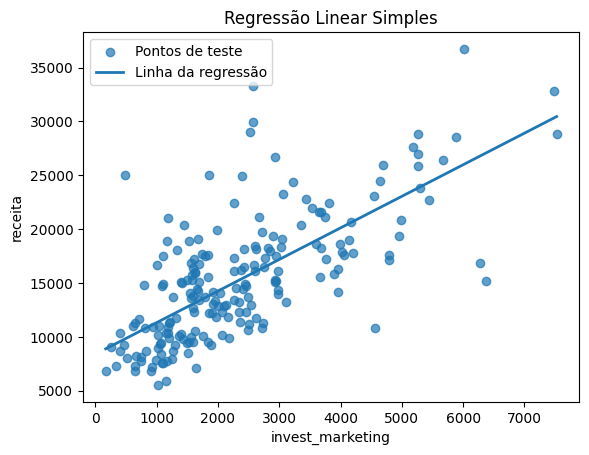

In [10]:
# ==============================
# Gráfico: Regressão Simples (dispersão + linha)
# ==============================
# Preparação dos dados para o gráfico
x_test_vals = Xte_simple.reshape(-1)      # Transforma matriz em vetor
order = np.argsort(x_test_vals)           # Obtém índices que ordenam os valores de x
x_sorted = x_test_vals[order].reshape(-1, 1)  # Ordena x para plotar linha contínua
y_line = lr_simple.predict(x_sorted)      # Calcula valores preditos para x ordenado

# Criação do gráfico
plt.figure()                              # Cria nova figura
plt.scatter(x_test_vals, yte,             # Plota pontos de dispersão
           alpha=0.7,                      # Define transparência
           label="Pontos de teste")        # Adiciona legenda
plt.plot(x_sorted.reshape(-1), y_line,    # Plota linha da regressão
         linewidth=2,                      # Define espessura da linha
         label="Linha da regressão")       # Adiciona legenda
plt.xlabel(SIMPLE_FEATURE)                # Rótulo do eixo x
plt.ylabel(TARGET_COL)                    # Rótulo do eixo y
plt.title("Regressão Linear Simples")  # Título
plt.legend()                              # Mostra legendas
plt.show()                                # Exibe o gráfico

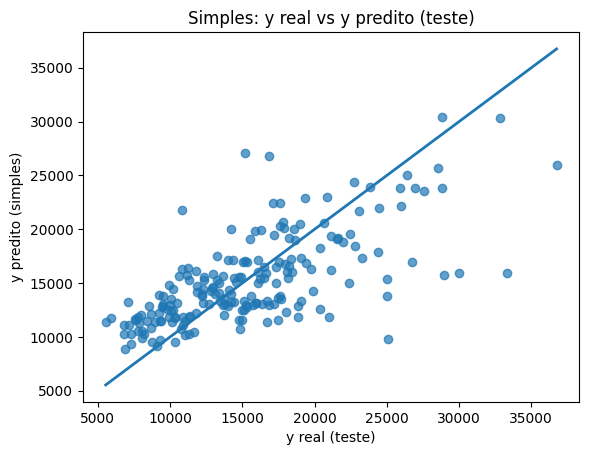

In [11]:
# ==============================
# Gráfico: y_real vs y_pred (Simples)
# ==============================
plt.figure()                              # Cria nova figura
plt.scatter(yte, ypred_simple,            # Plota valores reais vs preditos
           alpha=0.7)                      # Define transparência
plt.xlabel("y real (teste)")              # Rótulo do eixo x
plt.ylabel("y predito (simples)")         # Rótulo do eixo y
plt.title("Simples: y real vs y predito (teste)")  # Título

# Linha de referência y=x (diagonal perfeita)
lims = [
    min(yte.min(), ypred_simple.min()),   # Limite inferior
    max(yte.max(), ypred_simple.max())    # Limite superior
]
plt.plot(lims, lims,                      # Plota linha diagonal
         linewidth=2)                      # Define espessura
plt.show()                                # Exibe o gráfico

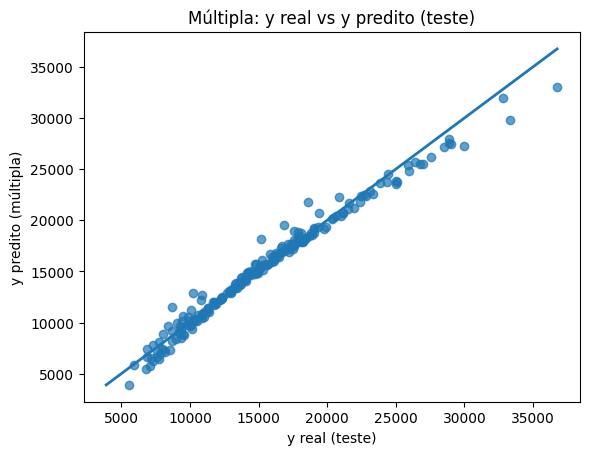

In [12]:
# ==============================
# Gráfico: y_real vs y_pred (Múltipla)
# ==============================
plt.figure()                              # Cria nova figura
plt.scatter(yte, ypred_multi,             # Plota valores reais vs preditos
           alpha=0.7)                      # Define transparência
plt.xlabel("y real (teste)")              # Rótulo do eixo x
plt.ylabel("y predito (múltipla)")        # Rótulo do eixo y
plt.title("Múltipla: y real vs y predito (teste)")  # Título

# Linha de referência y=x (diagonal perfeita)
lims = [
    min(yte.min(), ypred_multi.min()),    # Limite inferior
    max(yte.max(), ypred_multi.max())     # Limite superior
]
plt.plot(lims, lims,                      # Plota linha diagonal
         linewidth=2)                      # Define espessura
plt.show()                                # Exibe o gráfico

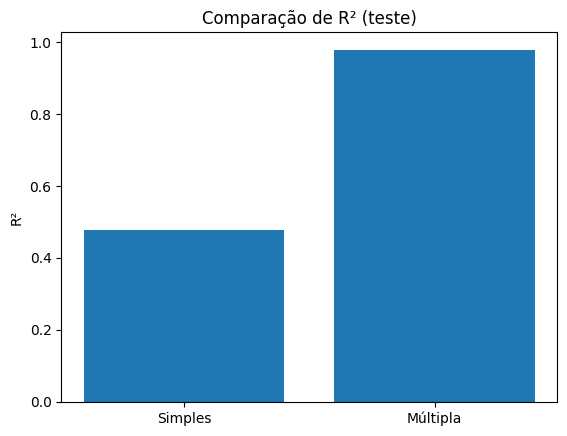

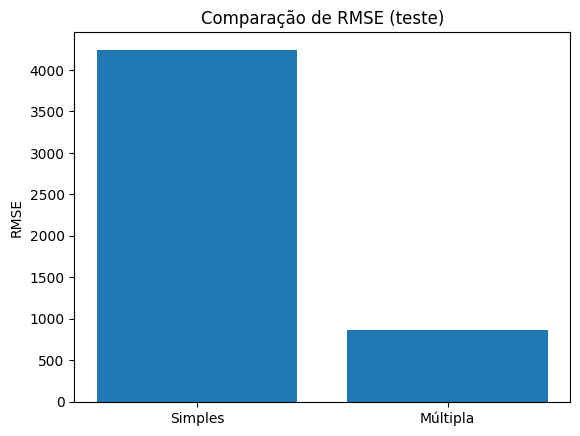

In [13]:
# ==============================
# Gráficos de comparação (barras) para R² e RMSE
# ==============================
# Cada métrica em um gráfico separado (sem subplots).

# Gráfico de barras para R²
plt.figure()                              # Cria nova figura
plt.bar(["Simples", "Múltipla"],          # Nomes das barras
        [res_simple["R2"], res_multi["R2"]])  # Valores de R² para cada modelo
plt.title("Comparação de R² (teste)")     # Título
plt.ylabel("R²")                          # Rótulo do eixo y
plt.show()                                # Exibe o gráfico

# Gráfico de barras para RMSE
plt.figure()                              # Cria nova figura
plt.bar(["Simples", "Múltipla"],          # Nomes das barras
        [res_simple["RMSE"], res_multi["RMSE"]])  # Valores de RMSE para cada modelo
plt.title("Comparação de RMSE (teste)")   # Título
plt.ylabel("RMSE")                        # Rótulo do eixo y
plt.show()                                # Exibe o gráfico

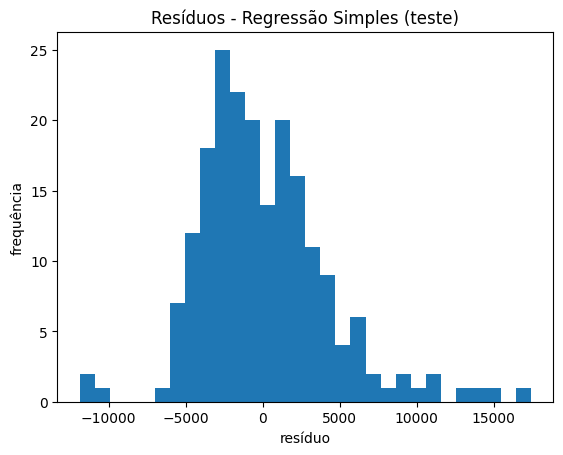

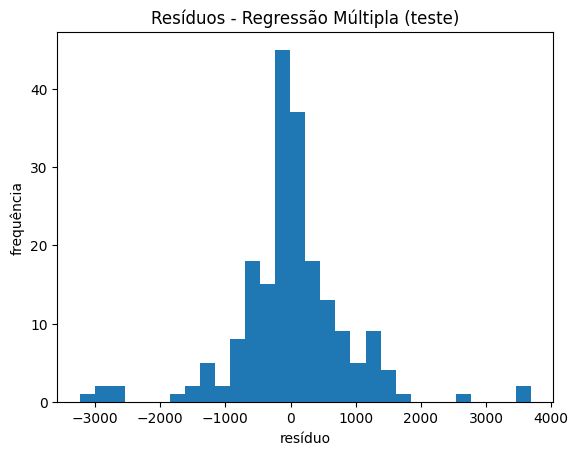

In [14]:
# ==============================
# Resíduos (Simples e Múltipla) - histogramas
# ==============================
# Calcula os resíduos (diferença entre valor real e predito)
resid_simple = yte - ypred_simple         # Resíduos da regressão simples
resid_multi  = yte - ypred_multi          # Resíduos da regressão múltipla

# Histograma dos resíduos da regressão simples
plt.figure()                              # Cria nova figura
plt.hist(resid_simple, bins=30)           # Plota histograma com 30 bins
plt.title("Resíduos - Regressão Simples (teste)")  # Título
plt.xlabel("resíduo")                     # Rótulo do eixo x
plt.ylabel("frequência")                  # Rótulo do eixo y
plt.show()                                # Exibe o gráfico

# Histograma dos resíduos da regressão múltipla
plt.figure()                              # Cria nova figura
plt.hist(resid_multi, bins=30)            # Plota histograma com 30 bins
plt.title("Resíduos - Regressão Múltipla (teste)")  # Título
plt.xlabel("resíduo")                     # Rótulo do eixo x
plt.ylabel("frequência")                  # Rótulo do eixo y
plt.show()                                # Exibe o gráfico

In [15]:
# ==============================
# Coeficientes da Regressão Múltipla (após pré-processamento)
# ==============================

#Importancia de cada variavel para prever RECEITA ( INTERCEPTO É A DISTANCIA DE Y ATÉ O EIXO X)
# Extraímos os componentes do pipeline
prep = pipe_multi.named_steps["prep"]      # Componente de pré-processamento
model = pipe_multi.named_steps["model"]    # Modelo de regressão

# Obtém os nomes das features após transformação
feature_names_out = prep.get_feature_names_out()  # Inclui features numéricas e dummies

# Cria uma Series pandas com os coeficientes ordenados
coefs = pd.Series(model.coef_,             # Coeficientes do modelo
                 index=feature_names_out)   # Nome das features
coefs = coefs.sort_values(ascending=False)  # Ordena do maior para o menor

# Mostra o intercepto (termo independente da equação)
print("Intercepto (múltipla):", model.intercept_)

# Mostra os 20 maiores coeficientes
display(coefs.to_frame("coeficiente").head(20))
# Mostra os 20 menores coeficientes
display(coefs.to_frame("coeficiente").tail(20))

Intercepto (múltipla): 15498.535256714746


,coeficiente
num__unidades_vendidas,4661.467354
num__preco,2452.941642
num__visitas_site,610.929151
num__emails_enviados,114.664563
cat__regiao_Sudeste,106.223345
cat__canal_Online,99.934829
cat__regiao_Nordeste,91.226304
cat__canal_Representante,72.571944
num__cliente_recorrente,69.860923
num__satisfacao,41.851521


,coeficiente
num__preco,2452.941642
num__visitas_site,610.929151
num__emails_enviados,114.664563
cat__regiao_Sudeste,106.223345
cat__canal_Online,99.934829
cat__regiao_Nordeste,91.226304
cat__canal_Representante,72.571944
num__cliente_recorrente,69.860923
num__satisfacao,41.851521
cat__regiao_Sul,41.568309


In [16]:
#Mede impacto real de cada feature, Gerando um score para cada variavel
#Desconsidera o coeficiente bruto que pode ser enganoso com dummies e escalas diferentes

# Calcula a importância de cada feature usando permutação
pi = permutation_importance(
    pipe_multi,           # Usa o pipeline completo que já treinamos
    Xte_multi,           # Usa os dados de teste (X) originais
    yte,                 # Usa os valores reais de teste (y)
    n_repeats=10,        # Repete o processo 10 vezes para ter uma média confiável
    random_state=RANDOM_STATE,  # Usa a mesma semente para reprodutibilidade
    scoring="r2"         # Usa R² como métrica para medir o impacto das permutações
)

# Obtém os nomes das features originais (antes do OneHotEncoder)
feature_names_perm = list(Xte_multi.columns)  # Converte os nomes das colunas em uma lista

# Cria um DataFrame organizado com os resultados da análise
pi_df = pd.DataFrame({
    "feature": feature_names_perm,          # Nome de cada feature
    "importance_mean": pi.importances_mean,  # Média da importância (quanto maior, mais importante)
    "importance_std": pi.importances_std     # Desvio padrão (indica variabilidade da importância)
}).sort_values(                             # Ordena o DataFrame
    "importance_mean",                      # Ordena pela coluna de importância média
    ascending=False                         # Ordena do maior para o menor (mais importante primeiro)
)

# Imprime o título para contextualizar os resultados
print("Importância por permutação (R²) - Top 15 (features originais):")

# Mostra as 15 features mais importantes do modelo
display(pi_df.head(15))  # head(15) seleciona apenas as 15 primeiras linhas do DataFrame

Importância por permutação (R²) - Top 15 (features originais):


,feature,importance_mean,importance_std
11,unidades_vendidas,1.117480,0.063242
4,preco,0.334050,0.016493
6,desconto_pct,0.027660,0.002829
2,visitas_site,0.023036,0.002260
3,emails_enviados,0.001261,0.000397
16,produto,0.000468,0.000199
9,cliente_recorrente,0.000451,0.000238
15,canal,0.000426,0.000210
10,sazonalidade_mes,0.000203,0.000148
5,preco_concorrente,0.000201,0.000080
